In [190]:
import jax.numpy as jnp
import os

# Create list of pdb files, and define a list of weights

In [191]:
import os
path_to_models="/Users/levans/Documents/Projects/Learning_Cryojax/data/hsp90_models"
model_fnames = []
for model_fname in sorted(os.listdir(path_to_models)):
    model_fnames.append(model_fname)

# Define weights
weights_models = (1/len(model_fnames))*jnp.ones(len(model_fnames))


# Define a config file

In [192]:
# Bare bones config for this notebook
config = {
"number_of_images": 50,
"noise_snr": 0.1,
"weights_models": weights_models,
"box_size": 128,
"models_fnames": model_fnames, 
"rng_seed": 0,
"path_to_models": path_to_models, 
"pixel_size": 1.6,
}
# Config with more options given more customizable parts as needed
#config = {
#"amplitude_contrast_ratio": 0.1, 
#"astigmatism_angle": 0.0,
#"astigmatism_in_angstroms": 0.0, 
#"batch_size": 5000,
#"box_size": 128,
#"ctf_scale_factor": 1.0,
#"defocus_in_angstroms": 150.0,
#"envelope_bfactor": 0.0,
#"experiment_name":"Heterogeneous dataset",
#"models_fnames": model_fnames, 
#"rng_seed": 0,
#"noise_snr": 0.1,
#"noise_radius_mask": 0.7,
#"number_of_images": 5000,
#"offset_x_in_angstroms": 0.0,
#"offset_y_in_angstroms": 0.0,
#"overwrite": True,
#"path_to_models": "/mnt/home/levans/Projects/cryo_sbvi/hsp90_models", 
#"path_to_relion_project": "/mnt/home/levans/Projects/cryo_sbvi/",
#"path_to_starfile": "/mnt/home/levans/Projects/cryo_sbvi/",
#"phase_shift": 0.0,
#"pixel_size": 2.0,
#"spherical_aberration_in_mm": 0.27,
#"voltage_in_kilovolts": 10.0,
#"weights_models": weights_models
#}


# Helper functions

In [193]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

# Simulate a dataset!

def prior():
...#sample weights in here

weights = prior.sample
simulate from weights....

In [194]:
import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb
from cryojax.image.operators import FourierGaussian
from cryojax.rotations import SO3
import jax
import equinox as eqx
import equinox.internal as eqxi
from jaxtyping import PRNGKeyArray, PyTree
import logging
from functools import partial


def build_image_formation_stuff(config):
    box_size = config["box_size"]
    pixel_size = config["pixel_size"]
    pdb_fnames = config["models_fnames"]
    path_to_models = config["path_to_models"]
    weights = jnp.array(config['weights_models'])
    
    rng_seed = config["rng_seed"] 
    number_of_images = config["number_of_images"]

    logging.info("Generating potentials...")
    potential_integrator = cxs.GaussianMixtureProjection()
    potentials = []
    for i in range(len(pdb_fnames)):
        filename = path_to_models + "/" + pdb_fnames[i]
        atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
            filename, assemble=False, get_b_factors=True
        )
        atomic_potential = cxs.PengAtomicPotential(atom_positions, atom_identities, b_factors)
        potentials.append(atomic_potential)
    potentials = tuple(potentials)
    print(potentials)
    logging.info("...Potentials generated")
    

    instrument_config = cxs.InstrumentConfig(
        shape=(box_size, box_size),
        pixel_size=pixel_size,
        voltage_in_kilovolts=300.0,
        pad_scale=1.0,
    )
    noise_grid = jnp.linspace(
          -0.5 * (box_size - 1),
          0.5 * (box_size - 1),
          box_size,
      )
    args = (instrument_config, potentials, potential_integrator, weights)
    return  args


@partial(eqx.filter_vmap, in_axes=(0, None), out_axes=eqxi.if_mapped(axis=0))
def make_imaging_pipeline(key, args):
    ## extract arguments
    instrument_config, potentials, potential_integrator, weights = args

    ## Key generation for imaging parameters
    # Rotation
    key, subkey = jax.random.split(key)  
    rotation = SO3.sample_uniform(subkey)

    # Translation
    key, subkey = jax.random.split(key)
    ny, nx = instrument_config.shape
    in_plane_offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=0, maxval=0) # maximum change is in a radius of 0.2 * box length
        * jnp.asarray((nx, ny))
        * instrument_config.pixel_size
    )
   
    # Convert 2D in-plane translation to 3D, set out-of-plane translation to 0
    offset_in_angstroms = jnp.pad(in_plane_offset_in_angstroms, ((0, 1),))

    # Build the pose
    pose = cxs.EulerAnglePose.from_rotation_and_translation(
        rotation, offset_in_angstroms
    )

    # defocus
    key, subkey = jax.random.split(key)
    defocus_in_angstroms = jax.random.uniform(
        subkey,
        (),
        minval=10000, # change to preferred values
        maxval=15000,
    )
    
    # astigmatism
    key, subkey = jax.random.split(key)
    astigmatism_in_angstroms = jax.random.uniform(
        subkey,
        (),
        minval=0,
        maxval=100,
    )
    key, subkey = jax.random.split(key)
    astigmatism_angle = jax.random.uniform(
        subkey,
        (),
        minval=0,
        maxval=jnp.pi,
    )
    
    # phase shift
    key, subkey = jax.random.split(key)
    phase_shift = jax.random.uniform(
        subkey, 
        (), 
        minval=0, 
        maxval=jnp.pi
    )
    
    # b_factor
    key, subkey = jax.random.split(key)
    b_factor = jax.random.uniform(
        subkey,
        (),
        minval=0, # For now, no b-factor
        maxval=0
    )

    # Various other ctf-y things
    spherical_aberration_in_mm = 2.7
    amplitude_contrast_ratio = 0.1
    ctf_scale_factor = 1.0

    ## Build the CTF
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.ContrastTransferFunction(
            defocus_in_angstroms=defocus_in_angstroms,
            astigmatism_in_angstroms=astigmatism_in_angstroms,
            astigmatism_angle=astigmatism_angle,
            spherical_aberration_in_mm=spherical_aberration_in_mm,
            amplitude_contrast_ratio=amplitude_contrast_ratio,
            phase_shift=phase_shift,
        ),
        envelope=FourierGaussian(b_factor=b_factor, amplitude=ctf_scale_factor),
    )

    ## Sample from potentials
    key, subkey = jax.random.split(key)
    structure_id = jax.random.choice(subkey, weights.shape[0], p=weights)
    
    structural_ensemble = cxs.DiscreteStructuralEnsemble(
        potentials,
        pose,
        cxs.DiscreteConformationalVariable(structure_id),
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble,
        potential_integrator,
        transfer_theory,
    )

    imaging_pipeline = cxs.ContrastImagingPipeline(
        instrument_config, scattering_theory
    )

    return imaging_pipeline 


In [195]:
#def build_image_formation_stuff(config):
#    box_size = config["box_size"]
#    pixel_size = config["pixel_size"]
#    pdb_fnames = config["models_fnames"]
#    path_to_models = config["path_to_models"]
#    rng_seed = config["rng_seed"] 
#    number_of_images = config["number_of_images"]
#
#    logging.info("Generating potentials...")
#    potential_integrator = cxs.GaussianMixtureProjection()
#    potentials = []
#    filename = path_to_models + "/" + pdb_fnames[0]
#    atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
#        filename, assemble=False, get_b_factors=True
#    )
#    potential = cxs.PengAtomicPotential(atom_positions, atom_identities, b_factors)
#    logging.info("...Potentials generated")
#
#    instrument_config = cxs.InstrumentConfig(
#        shape=(box_size, box_size),
#        pixel_size=pixel_size,
#        voltage_in_kilovolts=300.0,
#        pad_scale=1.0,
#    )
#    noise_grid = jnp.linspace(
#          -0.5 * (box_size - 1),
#          0.5 * (box_size - 1),
#          box_size,
#      )
#    args = (instrument_config, potentials, potential_integrator)
#    return  args
#
#
#@partial(eqx.filter_vmap, in_axes=(0, None), out_axes=eqxi.if_mapped(axis=0))
#def make_imaging_pipeline(key, args):
#    ## extract arguments
#    instrument_config, potential, potential_integrator = args
#
#    ## Key generation for imaging parameters
#    # Rotation
#    key, subkey = jax.random.split(key)  
#    rotation = SO3.sample_uniform(subkey)
#
#    # Translation
#    key, subkey = jax.random.split(key)
#    ny, nx = instrument_config.shape
#    in_plane_offset_in_angstroms = (
#        jax.random.uniform(subkey, (2,), minval=0, maxval=0) # maximum change is in a radius of 0.2 * box length
#        * jnp.asarray((nx, ny))
#        * instrument_config.pixel_size
#    )
#   
#    # Convert 2D in-plane translation to 3D, set out-of-plane translation to 0
#    offset_in_angstroms = jnp.pad(in_plane_offset_in_angstroms, ((0, 1),))
#
#    # Build the pose
#    pose = cxs.EulerAnglePose.from_rotation_and_translation(
#        rotation, offset_in_angstroms
#    )
#
#    # defocus
#    key, subkey = jax.random.split(key)
#    defocus_in_angstroms = jax.random.uniform(
#        subkey,
#        (),
#        minval=10000, # change to preferred values
#        maxval=15000,
#    )
#    
#    # astigmatism
#    key, subkey = jax.random.split(key)
#    astigmatism_in_angstroms = jax.random.uniform(
#        subkey,
#        (),
#        minval=0,
#        maxval=100,
#    )
#    key, subkey = jax.random.split(key)
#    astigmatism_angle = jax.random.uniform(
#        subkey,
#        (),
#        minval=0,
#        maxval=jnp.pi,
#    )
#    
#    # phase shift
#    key, subkey = jax.random.split(key)
#    phase_shift = jax.random.uniform(
#        subkey, 
#        (), 
#        minval=0, 
#        maxval=jnp.pi
#    )
#    
#    # b_factor
#    key, subkey = jax.random.split(key)
#    b_factor = jax.random.uniform(
#        subkey,
#        (),
#        minval=0, # For now, no b-factor
#        maxval=0
#    )
#
#    # Various other ctf-y things
#    spherical_aberration_in_mm = 2.7
#    amplitude_contrast_ratio = 0.1
#    ctf_scale_factor = 1.0
#
#    ## Build the CTF
#    transfer_theory = cxs.ContrastTransferTheory(
#        ctf=cxs.ContrastTransferFunction(
#            defocus_in_angstroms=defocus_in_angstroms,
#            astigmatism_in_angstroms=astigmatism_in_angstroms,
#            astigmatism_angle=astigmatism_angle,
#            spherical_aberration_in_mm=spherical_aberration_in_mm,
#            amplitude_contrast_ratio=amplitude_contrast_ratio,
#            phase_shift=phase_shift,
#        ),
#        envelope=FourierGaussian(b_factor=b_factor, amplitude=ctf_scale_factor),
#    )
#
#    ## Sample from potentials
#    #key, subkey = jax.random.split(key)
#    #structure_id = jax.random.choice(subkey, weights.shape[0], p=weights)
#
#    #structural_ensemble = cxs.DiscreteStructuralEnsemble(
#    #    potential,
#    #    pose,
#    #    cxs.DiscreteConformationalVariable(structure_id),
#    #)
#    structural_ensemble = cxs.SingleStructureEnsemble(potential, pose)
#
#
#    scattering_theory = cxs.WeakPhaseScatteringTheory(
#        structural_ensemble,
#        potential_integrator,
#        transfer_theory,
#    )
#
#    imaging_pipeline = cxs.ContrastImagingPipeline(
#        instrument_config, scattering_theory
#    )
#
#    return imaging_pipeline 



In [196]:
# Generate RNG keys
key = jax.random.PRNGKey(0)

key, *subkeys = jax.random.split(key, config["number_of_images"] + 1)
subkeys = jnp.array(subkeys)
print(subkeys.shape)
args = build_image_formation_stuff(config)
imaging_pipeline = make_imaging_pipeline(subkeys, args)

(50, 2)
(PengAtomicPotential(
  atom_positions=f32[9758,3],
  scattering_factor_a=f32[9758,5],
  scattering_factor_b=f32[9758,5],
  b_factors=f32[9758]
), PengAtomicPotential(
  atom_positions=f32[9758,3],
  scattering_factor_a=f32[9758,5],
  scattering_factor_b=f32[9758,5],
  b_factors=f32[9758]
), PengAtomicPotential(
  atom_positions=f32[9758,3],
  scattering_factor_a=f32[9758,5],
  scattering_factor_b=f32[9758,5],
  b_factors=f32[9758]
), PengAtomicPotential(
  atom_positions=f32[9758,3],
  scattering_factor_a=f32[9758,5],
  scattering_factor_b=f32[9758,5],
  b_factors=f32[9758]
), PengAtomicPotential(
  atom_positions=f32[9758,3],
  scattering_factor_a=f32[9758,5],
  scattering_factor_b=f32[9758,5],
  b_factors=f32[9758]
), PengAtomicPotential(
  atom_positions=f32[9758,3],
  scattering_factor_a=f32[9758,5],
  scattering_factor_b=f32[9758,5],
  b_factors=f32[9758]
), PengAtomicPotential(
  atom_positions=f32[9758,3],
  scattering_factor_a=f32[9758,5],
  scattering_factor_b=f32[975

In [197]:
from cryojax import get_filter_spec


def _pointer_to_vmapped_parameters(imaging_pipeline):
    output = (
        imaging_pipeline.scattering_theory.transfer_theory.ctf.defocus_in_angstroms,
        imaging_pipeline.scattering_theory.transfer_theory.ctf.astigmatism_in_angstroms,
        imaging_pipeline.scattering_theory.transfer_theory.ctf.astigmatism_angle,
        imaging_pipeline.scattering_theory.transfer_theory.ctf.phase_shift,
        imaging_pipeline.scattering_theory.transfer_theory.envelope.b_factor,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.offset_x_in_angstroms,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.offset_y_in_angstroms,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_phi,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_theta,
        imaging_pipeline.scattering_theory.structural_ensemble.pose.view_psi,
        imaging_pipeline.scattering_theory.structural_ensemble.conformation
    )
    return output

def _get_imaging_pipeline_filter_spec(imaging_pipeline):
    return get_filter_spec(imaging_pipeline, _pointer_to_vmapped_parameters)

filter_spec = _get_imaging_pipeline_filter_spec(imaging_pipeline)


In [198]:
import cryojax as cx


@partial(cx.filter_vmap_with_spec, filter_spec=filter_spec)
def compute_image_stack(imaging_pipeline):
    """Compute a batch of images at different poses,
    specified by the `filter_spec`.
    """
    return imaging_pipeline.render()

images = compute_image_stack(imaging_pipeline)

In [199]:

# get conformations
print(imaging_pipeline.scattering_theory.structural_ensemble.conformation.value)

# get poses
print(imaging_pipeline.scattering_theory.structural_ensemble.pose.view_phi)

# get poses
print(imaging_pipeline.scattering_theory.structural_ensemble.pose.view_phi)




[ 8 15  0  4  9  5  0  3  8 14 14  4  8 17 12 19 12 14  7 14 10  4  4 19
  4  6 12 16 19  0 13  7  0 11  6 13 10  1 12  4 18 17  7 11  4 17 13 16
  2 16]
[-129.12906     24.276009  -137.32993     40.387005   -75.854416
   21.543783   -72.82267    -13.214272    97.43463     -6.3568025
   71.05893     78.47326     -5.6389494 -150.60524    -13.81903
 -168.12643   -170.31755    100.63127    -46.519367   -76.671875
 -102.31401     70.83416    116.371796   157.3431    -110.55329
  138.23752     44.42362     -3.360904  -151.37561     63.732456
 -159.47737     33.96969    -59.14254    -15.754228   -52.875187
   93.36556    137.6229     -62.639503    99.80561     78.2836
   -1.2665766 -109.77897    146.58456     71.99234   -115.285355
   98.693924   -76.41923    154.34918    129.98761    -59.9248   ]
[-129.12906     24.276009  -137.32993     40.387005   -75.854416
   21.543783   -72.82267    -13.214272    97.43463     -6.3568025
   71.05893     78.47326     -5.6389494 -150.60524    -13.81903
 -

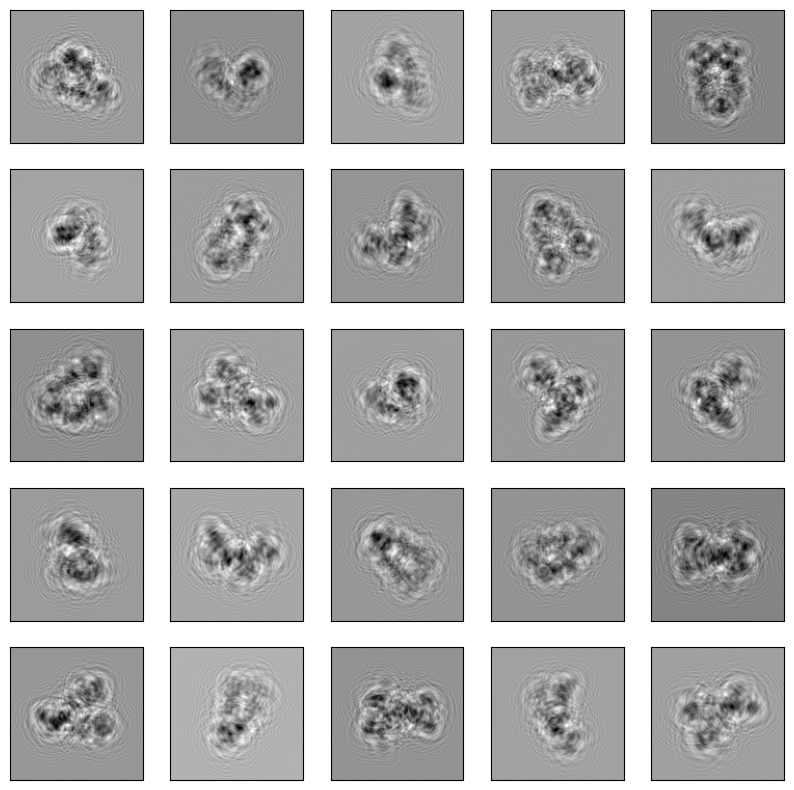

In [200]:
import matplotlib.pyplot as plt
#print(images.shape)
#for i in range(10):
#    plt.figure()
#    plt.imshow(images[i], cmap="gray")
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[idx,:], cmap="gray")
    ax.set_yticks([])
    ax.set_xticks([])
#plt.savefig(f"figures/noised_images", dpi=300)



# Next: add noise